# Raw → 전처리 → 시각화 → 전망 모델 학습

- **0단계**: Raw 로드 (추정매출 CSV + 거시 CSV) → 패널 생성
- **1단계**: 전망용 데이터셋 (lag, rolling, target_next, quarter 더미)
- **2단계**: EDA 시각화 (성장률 분포, shock 시계열, 학습 후 예측 vs 실제)
- **3단계**: h=1 Quantile 모델 학습 → MAE/RMSE → pkl 저장 → 샘플 3개 전망 출력

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd() if Path.cwd().name != "notebooks" else Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
OUTPUTS_NB = PROJECT_ROOT / "outputs" / "notebook"
OUTPUTS_NB.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

## 1. Raw 로드 및 패널 생성

In [2]:
# 추정매출 CSV 경로 수집 (data/raw 또는 data/raw/seoul_sales)
all_sales = []
for base in (DATA_RAW / "seoul_sales", DATA_RAW):
    if not base.exists():
        continue
    for year in ("2020", "2021", "2022", "2023", "2024"):
        all_sales.extend(base.glob(f"*{year}*.csv"))
sales_paths = sorted(
    set(p for p in all_sales if "상권변화" not in p.name and "행정동" not in p.name),
    key=lambda p: p.name,
)
if not sales_paths:
    raise FileNotFoundError("추정매출 CSV가 없습니다. data/raw/ 또는 data/raw/seoul_sales/ 확인.")
print(f"매출 CSV {len(sales_paths)}개: {[p.name for p in sales_paths[:3]]}...")

매출 CSV 5개: ['서울시 상권분석서비스(추정매출-상권)_2024년.csv', '서울시_상권분석서비스(추정매출-상권)_2020년.csv', '서울시_상권분석서비스(추정매출-상권)_2021년.csv']...


In [3]:
from src.data.seoul_sales import load_seoul_sales, add_growth_features
from src.data.macro_quarterly import load_macro_quarterly, add_macro_derivatives

sales = load_seoul_sales([str(p) for p in sales_paths])
sales = add_growth_features(sales)
macro_path = DATA_PROCESSED / "macro_quarterly.csv"
if not macro_path.exists():
    raise FileNotFoundError(f"거시지표 없음: {macro_path}")
macro = load_macro_quarterly(macro_path)
macro = add_macro_derivatives(macro, shock_periods=None)
sales_panel = sales.merge(
    macro,
    on=["year", "quarter", "year_quarter"],
    how="left",
    validate="m:1",
)
print(f"sales_panel: {sales_panel.shape}")

sales_panel: (434199, 35)


## 2. 전망용 데이터셋 (lag, rolling, target_next, quarter 더미)

rolling_mean_4q / rolling_std_4q는 패널에 없으므로 여기서 그룹별 rolling(4) 계산.

In [4]:
from src.models.rank_dataset import add_rank_features, add_target_encoding
from src.models.datasets import temporal_train_test_split

FORECAST_TARGET_COL = "target_next"
min_sales = 1_000_000.0

df = sales_panel.sort_values(["region_id", "sector_code", "year", "quarter"]).copy()
if "log_sales" not in df.columns:
    df["log_sales"] = np.log1p(df["sales"].fillna(0))
df[FORECAST_TARGET_COL] = df.groupby(["region_id", "sector_code"], sort=False)["log_sales"].shift(-1)
df = add_rank_features(df)
for q in (2, 3, 4):
    df[f"quarter_{q}"] = (df["quarter"] == q).astype(int)
df = df.dropna(subset=[FORECAST_TARGET_COL])
df = df.loc[df["sales"].fillna(0) >= min_sales].copy()
print(f"전망용 행 수: {len(df)}")

전망용 행 수: 403763


In [5]:
def get_forecast_feature_columns(df, target_col=FORECAST_TARGET_COL):
    drop = {
        "region_id", "sector_code", "sector_name", "region_name",
        "year", "quarter", "year_quarter", "rank_group",
        "sales", "sales_prev", "transactions", "transactions_prev",
        "sales_growth_qoq", "sales_growth_log", "log_sales",
        "target_log_sales_next", target_col, "quarter_code",
    }
    return [c for c in df.columns
            if str(df[c].dtype) in ("int16", "int32", "int64", "float16", "float32", "float64")
            and c not in drop]

train_df, test_df = temporal_train_test_split(df, test_start_year=2023, test_start_quarter=1)
train_df, test_df = add_target_encoding(
    train_df, test_df,
    target_col=FORECAST_TARGET_COL,
    encode_cols=["region_id", "sector_code"],
)
feature_cols = get_forecast_feature_columns(train_df)
print(f"피처 수: {len(feature_cols)}", feature_cols[:12])

피처 수: 25 ['txn_growth_qoq', 'cpi', 'policy_rate', 'unemployment', 'ccsi', 'cpi_yoy', 'ccsi_diff', 'policy_rate_diff', 'unemployment_diff', 'shock_score', 'macro_shock', 'shock_index_raw_x']


## 3. EDA 시각화

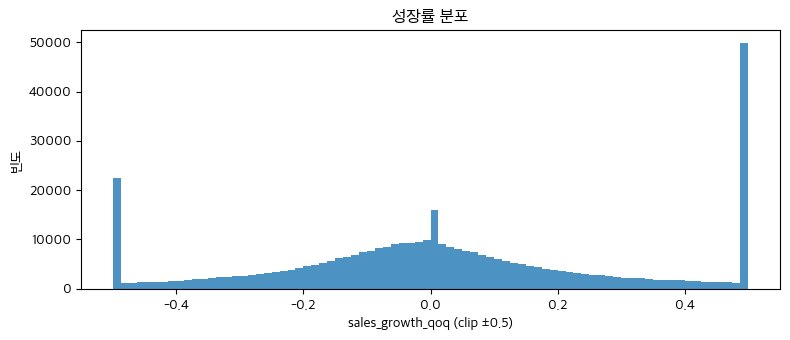

In [6]:
from src.config.mpl_font import setup_mpl_font
setup_mpl_font()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 3.5))
g = sales_panel["sales_growth_qoq"].replace([np.inf, -np.inf], np.nan).dropna()
g = g.clip(-0.5, 0.5)
ax.hist(g, bins=80, edgecolor="none", alpha=0.8)
ax.set_xlabel("sales_growth_qoq (clip ±0.5)")
ax.set_ylabel("빈도")
ax.set_title("성장률 분포")
plt.tight_layout()
plt.savefig(OUTPUTS_NB / "sales_growth_qoq_hist.png", dpi=150, bbox_inches="tight")
plt.show()

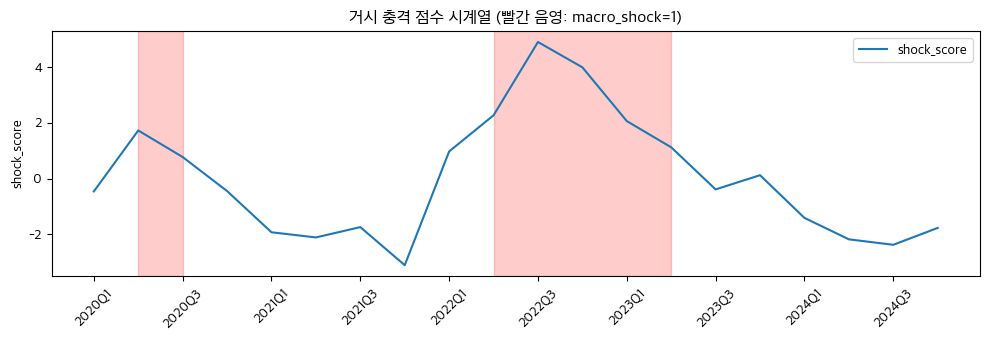

In [7]:
if "shock_score" in macro.columns:
    by_q = macro[["year_quarter", "year", "quarter", "shock_score", "macro_shock"]].sort_values(["year", "quarter"])
    fig, ax = plt.subplots(figsize=(10, 3.5))
    x = np.arange(len(by_q))
    ax.plot(x, by_q["shock_score"].values, label="shock_score")
    shock = by_q["macro_shock"].values
    i = 0
    while i < len(shock):
        if shock[i] == 1:
            j = i
            while j < len(shock) and shock[j] == 1:
                j += 1
            ax.axvspan(i, j, alpha=0.2, color="red")
            i = j
        else:
            i += 1
    ax.set_xticks(x[::2])
    ax.set_xticklabels(by_q["year_quarter"].iloc[::2], rotation=45)
    ax.set_ylabel("shock_score")
    ax.legend()
    ax.set_title("거시 충격 점수 시계열 (빨간 음영: macro_shock=1)")
    plt.tight_layout()
    plt.savefig(OUTPUTS_NB / "shock_score_timeseries.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("macro에 shock_score 없음 → 시계열 스킵")

## 4. h=1 Quantile 모델 학습

In [8]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[FORECAST_TARGET_COL].values
X_test = test_df[feature_cols].fillna(0)
y_test = test_df[FORECAST_TARGET_COL].values

base = dict(n_estimators=300, learning_rate=0.05, max_depth=6, num_leaves=31,
            min_child_samples=50, subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1)
models = {}
for name, alpha in [("p10", 0.1), ("p50", 0.5), ("p90", 0.9)]:
    m = LGBMRegressor(**base, objective="quantile", alpha=alpha)
    m.fit(X_train, y_train)
    models[name] = m

pred_p50 = models["p50"].predict(X_test)
mae = mean_absolute_error(y_test, pred_p50)
rmse = np.sqrt(((y_test - pred_p50) ** 2).mean())
print("--- 성능 (Test, 중앙값 예측) ---")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")

--- 성능 (Test, 중앙값 예측) ---
  MAE:  0.2744
  RMSE: 0.5045


In [9]:
import joblib
import json

for name, m in models.items():
    joblib.dump(m, MODELS_DIR / f"forecast_{name}.pkl")
with open(MODELS_DIR / "forecast_feature_cols.json", "w", encoding="utf-8") as f:
    json.dump({"feature_cols": feature_cols}, f, ensure_ascii=False, indent=2)
print(f"저장: {MODELS_DIR}/forecast_p10.pkl, forecast_p50.pkl, forecast_p90.pkl, forecast_feature_cols.json")

저장: /Users/LEEJIWOO/Desktop/new_ml_project/models/forecast_p10.pkl, forecast_p50.pkl, forecast_p90.pkl, forecast_feature_cols.json


## 5. 예측 vs 실제 산점도

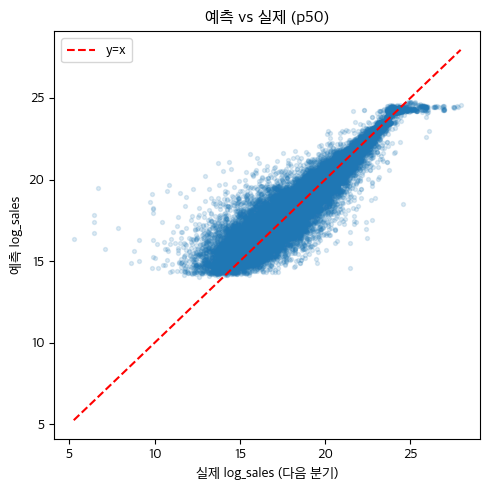

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_test, pred_p50, alpha=0.15, s=8)
mx = max(y_test.max(), pred_p50.max())
mn = min(y_test.min(), pred_p50.min())
ax.plot([mn, mx], [mn, mx], "r--", label="y=x")
ax.set_xlabel("실제 log_sales (다음 분기)")
ax.set_ylabel("예측 log_sales")
ax.set_title("예측 vs 실제 (p50)")
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUTS_NB / "predicted_vs_actual.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. 샘플 상권 3개 다음 분기 전망

In [11]:
def log_to_million(log_sales):
    return max(0.0, np.expm1(log_sales) / 1e6)

uniq = test_df.groupby(["region_id", "sector_code"]).agg({"year": "max", "quarter": "max"}).reset_index().head(3)
print("--- 샘플 상권 3개 다음 분기 전망 ---")
for _, r in uniq.iterrows():
    rid, sid = r["region_id"], r["sector_code"]
    row = test_df[(test_df["region_id"] == rid) & (test_df["sector_code"] == sid)].sort_values(["year", "quarter"]).iloc[-1:]
    if row.empty:
        continue
    X_row = row[feature_cols].fillna(0)
    p10 = models["p10"].predict(X_row)[0]
    p50 = models["p50"].predict(X_row)[0]
    p90 = models["p90"].predict(X_row)[0]
    m10, m50, m90 = log_to_million(p10), log_to_million(p50), log_to_million(p90)
    current = row["log_sales"].iloc[0]
    current_m = log_to_million(current)
    growth_pct = (m50 - current_m) / current_m * 100.0 if current_m > 0 else 0.0
    rn = row["region_name"].iloc[0] if "region_name" in row.columns else rid
    sn = row["sector_name"].iloc[0] if "sector_name" in row.columns else sid
    print(f"  [{rn} × {sn}]")
    print(f"    다음 분기 예상 매출(중앙): {m50:.1f}백만원 ({m50/100:.1f}억원)")
    print(f"    보수~낙관: {m10:.1f} ~ {m90:.1f} 백만원")
    print(f"    전분기 대비 변화율: {growth_pct:+.1f}%")
    print()

--- 샘플 상권 3개 다음 분기 전망 ---
  [이태원 관광특구 × 한식음식점]
    다음 분기 예상 매출(중앙): 15707.2백만원 (157.1억원)
    보수~낙관: 13246.0 ~ 19405.0 백만원
    전분기 대비 변화율: +23.0%

  [이태원 관광특구 × 중식음식점]
    다음 분기 예상 매출(중앙): 1901.0백만원 (19.0억원)
    보수~낙관: 1678.2 ~ 2068.6 백만원
    전분기 대비 변화율: +1.5%

  [이태원 관광특구 × 일식음식점]
    다음 분기 예상 매출(중앙): 698.5백만원 (7.0억원)
    보수~낙관: 582.5 ~ 864.5 백만원
    전분기 대비 변화율: +10.5%

